In [1]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData

In [2]:

df=pd.read_csv('finalized_data.csv')

In [3]:
df['score'] = df['score'].round(2)

Disease Specificity Index
There are genes (or variants) that are associated with multiple diseases (e.g., TNF) while others are associated with a small set of diseases or even to a single disease. The Disease Specificity Index (DSI) is a measure of this property of the genes (and variants). It reflects if a gene (or variant) is associated to several or fewer diseases.

Disease Pleiotropy Index
The rationale is similar to the DSI, but we consider if the multiple diseases associated with the gene (or variant) are similar among them (belong to the same MeSH disease class, e.g., Cardiovascular Diseases) or are completely different diseases and belong to different disease classes.

In [4]:

df = df.drop_duplicates()
print(f"Number of lines after removing duplicates: {len(df)}")


Number of lines after removing duplicates: 5955


In [5]:
import torch
from torch_geometric.data import HeteroData

# Assuming df is your DataFrame

# Prepare gene node features using gene_index as indices
genes = df[['gene_index', 'geneDSI', 'geneDPI']].drop_duplicates().set_index('gene_index')
num_genes = genes.index.max() + 1  # Assuming indices start from 0
gene_features = torch.zeros((num_genes, 2), dtype=torch.float)
gene_features[genes.index] = torch.tensor(genes[['geneDSI', 'geneDPI']].values, dtype=torch.float)

# Prepare disease nodes
diseases = df[['disease_index']].drop_duplicates().set_index('disease_index')
num_diseases = diseases.index.max() + 1  # Assuming indices start from 0

# Prepare edge indices using existing indices
edge_index = torch.tensor([
    df['gene_index'].values,
    df['disease_index'].values
], dtype=torch.long)

# Edge attributes (scores)
edge_attr = torch.tensor(df['score'].values, dtype=torch.float).unsqueeze(1)

# Create HeteroData object
data = HeteroData()

# Add gene node features
data['gene'].x = gene_features

# Set the number of disease nodes (no features)
data['disease'].num_nodes = num_diseases

# Add edges between genes and diseases with edge attributes
data['gene', 'associates_with', 'disease'].edge_index = edge_index
data['gene', 'associates_with', 'disease'].edge_attr = edge_attr

C:\Users\Marci\AppData\Local\Temp\ipykernel_14200\2655784945.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor([


In [6]:
data

HeteroData(
  gene={ x=[3608, 2] },
  disease={ num_nodes=23 },
  (gene, associates_with, disease)={
    edge_index=[2, 5955],
    edge_attr=[5955, 1],
  }
)

In [7]:
import torch_geometric.transforms as T
# Add reverse edges to allow message passing in both directions
# Convert the graph to undirected (adds reverse edges)
data = T.ToUndirected()(data)

# Define the edge types for splitting
edge_types = ('gene', 'associates_with', 'disease')
rev_edge_types = ('disease', 'rev_associates_with', 'gene')  # Reverse edge type

# Perform RandomLinkSplit with corrected parameter
transform = T.RandomLinkSplit(
    num_val=0.1,                     # 10% for validation
    num_test=0.1,                    # 10% for testing
    disjoint_train_ratio=0.3,        # 30% of training edges for supervision
    neg_sampling_ratio=2.0,          # Negative edge ratio for evaluation
    is_undirected=True,              # Graph is undirected
    add_negative_train_samples=False,  # Negative edges generated on-the-fly during training
    edge_types=edge_types,
    rev_edge_types=rev_edge_types,
)

In [8]:
train_data, val_data, test_data = transform(data)

In [9]:
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

print("Training data edges (gene -> disease):", train_data["gene", "associates_with", "disease"].num_edges)
print("Training data edge label index size:", train_data["gene", "associates_with", "disease"].edge_label_index.size(1))
print("Training data edges (disease -> gene):", train_data["disease", "rev_associates_with", "gene"].num_edges)
print("Training data edge label min:", train_data["gene", "associates_with", "disease"].edge_label.min())
print("Training data edge label max:", train_data["gene", "associates_with", "disease"].edge_label.max())

print("Validation data edges (gene -> disease):", val_data["gene", "associates_with", "disease"].num_edges)
print("Validation data edge label index size:", val_data["gene", "associates_with", "disease"].edge_label_index.size(1))
print("Validation data edges (disease -> gene):", val_data["disease", "rev_associates_with", "gene"].num_edges)
print("Validation data edge label bincount:", val_data["gene", "associates_with", "disease"].edge_label.long().bincount().tolist())


Training data:
HeteroData(
  gene={ x=[3608, 2] },
  disease={ num_nodes=23 },
  (gene, associates_with, disease)={
    edge_index=[2, 3336],
    edge_attr=[3336, 1],
    edge_label=[1429],
    edge_label_index=[2, 1429],
  },
  (disease, rev_associates_with, gene)={
    edge_index=[2, 3336],
    edge_attr=[3336, 1],
  }
)

Validation data:
HeteroData(
  gene={ x=[3608, 2] },
  disease={ num_nodes=23 },
  (gene, associates_with, disease)={
    edge_index=[2, 4765],
    edge_attr=[4765, 1],
    edge_label=[1785],
    edge_label_index=[2, 1785],
  },
  (disease, rev_associates_with, gene)={
    edge_index=[2, 4765],
    edge_attr=[4765, 1],
  }
)
Training data edges (gene -> disease): 3336
Training data edge label index size: 1429
Training data edges (disease -> gene): 3336
Training data edge label min: tensor(1.)
Training data edge label max: tensor(1.)
Validation data edges (gene -> disease): 4765
Validation data edge label index size: 1785
Validation data edges (disease -> gene): 4765

In [10]:
for split_name, split_data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    edge = split_data['gene', 'associates_with', 'disease']
    print(f"{split_name} Data:")
    print(f"  edge_label_index shape: {edge.edge_label_index.shape}")
    print(f"  edge_label shape: {edge.edge_label.shape}")
    print(f"  Max edge_label_index: {edge.edge_label_index.max().item()}")
    print()

Train Data:
  edge_label_index shape: torch.Size([2, 1429])
  edge_label shape: torch.Size([1429])
  Max edge_label_index: 3603

Validation Data:
  edge_label_index shape: torch.Size([2, 1785])
  edge_label shape: torch.Size([1785])
  Max edge_label_index: 3607

Test Data:
  edge_label_index shape: torch.Size([2, 1785])
  edge_label shape: torch.Size([1785])
  Max edge_label_index: 3607



In [11]:
from torch_geometric.loader import LinkNeighborLoader

# Define the edge type for link prediction
edge_label_index = ('gene', 'associates_with', 'disease')

# Training data loader
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[10, 5],
    batch_size=128,
    edge_label_index=(
        edge_label_index,
        train_data[edge_label_index].edge_label_index
    ),
    edge_label=train_data[edge_label_index].edge_label,
    neg_sampling_ratio=2.0,
    shuffle=True
)

# Validation data loader
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[10, 5],
    batch_size=128,
    edge_label_index=(
        edge_label_index,
        val_data[edge_label_index].edge_label_index
    ),
    edge_label=val_data[edge_label_index].edge_label,
    shuffle=False
)

# Test data loader
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[10, 5],
    batch_size=128,
    edge_label_index=(
        edge_label_index,
        test_data[edge_label_index].edge_label_index
    ),
    edge_label=test_data[edge_label_index].edge_label,
    shuffle=False
)



# Verify a few things

In [12]:
batch = next(iter(train_loader))
print("Batch edge_label_index shape:", batch[edge_label_index].edge_label_index.shape)
print("Batch edge_label shape:", batch[edge_label_index].edge_label.shape)
print("Batch positive labels:", (batch[edge_label_index].edge_label == 1).sum().item())
print("Batch negative labels:", (batch[edge_label_index].edge_label == 0).sum().item())

Batch edge_label_index shape: torch.Size([2, 384])
Batch edge_label shape: torch.Size([384])
Batch positive labels: 128
Batch negative labels: 256


3. Check the distribution of edge labels

Count the number of positive and negative labels to ensure they are correctly assigned.

In [13]:
for split_name, split_data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    edge = split_data['gene', 'associates_with', 'disease']
    labels = edge.edge_label
    pos_labels = (labels == 1).sum().item()
    neg_labels = (labels == 0).sum().item()
    print(f"{split_name} Data:")
    print(f"  Positive labels (edges): {pos_labels}")
    print(f"  Negative labels (non-edges): {neg_labels}")
    print()

Train Data:
  Positive labels (edges): 1429
  Negative labels (non-edges): 0

Validation Data:
  Positive labels (edges): 595
  Negative labels (non-edges): 1190

Test Data:
  Positive labels (edges): 595
  Negative labels (non-edges): 1190



4. Inspect a small sample of edges and labels

View a few edges and their corresponding labels to manually verify correctness.

In [14]:
split_data = train_data  # Replace with val_data or test_data as needed
edge = split_data['gene', 'associates_with', 'disease']

# View the first 5 edges and labels
print("First 5 edges:")
print(edge.edge_label_index[:, :5])
print("Corresponding labels:")
print(edge.edge_label[:5])

First 5 edges:
tensor([[1725, 3063, 3076, 1392, 1020],
        [  15,   18,   19,   19,    8]])
Corresponding labels:
tensor([1., 1., 1., 1., 1.])


5. Verify that positive edges correspond to actual connections

For a few positive labels, confirm that the edges exist in original DataFrame or data object

In [15]:
# Assuming you have access to the original edge indices
original_edges = data['gene', 'associates_with', 'disease'].edge_index

# Compare with the training edges
train_edges = train_data['gene', 'associates_with', 'disease'].edge_label_index

# Check if training edges are a subset of original edges
edge_pairs = set(map(tuple, original_edges.t().tolist()))
train_edge_pairs = set(map(tuple, train_edges.t().tolist()))
print("All training edges are in the original edges:", train_edge_pairs.issubset(edge_pairs))

All training edges are in the original edges: True


6. Confirm that negative samples are not in the original edges
For validation and test splits, ensure that negative samples do not exist in the actual graph

In [16]:
split_name = 'Validation'  # or 'Test'
split_data = val_data if split_name == 'Validation' else test_data
edge = split_data['gene', 'associates_with', 'disease']

# Get negative edge indices
neg_edge_indices = edge.edge_label_index[:, edge.edge_label == 0]

# Convert to set of edge pairs
neg_edge_pairs = set(map(tuple, neg_edge_indices.t().tolist()))

# Check if any negative edges are in the original edges
common_edges = neg_edge_pairs.intersection(edge_pairs)
print(f"Number of negative {split_name.lower()} edges in original edges:", len(common_edges))

Number of negative validation edges in original edges: 0


In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class LinkPredictor(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x_gene, x_disease, edge_label_index):
        row, col = edge_label_index
        x = torch.cat([x_gene[row], x_disease[col]], dim=-1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return x.squeeze()

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        
        # Gene features: DSI and DPI (2 features)
        self.gene_lin = torch.nn.Linear(2, hidden_channels)
        
        # Disease has no features, learn embeddings
        self.disease_emb = torch.nn.Embedding(23, hidden_channels)  # 23 diseases
        
        # GNN for learning node representations
        self.gnn = GNN(hidden_channels)
        
        # Convert to heterogeneous GNN
        self.gnn = to_hetero(self.gnn, data.metadata())
        
        # Link predictor
        self.predictor = LinkPredictor(hidden_channels)

    def forward(self, data):
        x_dict = {
            'gene': self.gene_lin(data['gene'].x),
            'disease': self.disease_emb(torch.arange(data['disease'].num_nodes).to(data['gene'].x.device))
        }

        # Apply GNN
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        # Predict links
        return self.predictor(
            x_dict['gene'],
            x_dict['disease'],
            data['gene', 'associates_with', 'disease'].edge_label_index,
        )

# Initialize model
model = Model(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
print(model)

Model(
  (gene_lin): Linear(in_features=2, out_features=64, bias=True)
  (disease_emb): Embedding(23, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (gene__associates_with__disease): SAGEConv(64, 64, aggr=mean)
      (disease__rev_associates_with__gene): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (gene__associates_with__disease): SAGEConv(64, 64, aggr=mean)
      (disease__rev_associates_with__gene): SAGEConv(64, 64, aggr=mean)
    )
  )
  (predictor): LinkPredictor(
    (lin1): Linear(in_features=128, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
# Device setup
from sklearn.metrics import roc_auc_score
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_losses = []
val_aucs = []
test_aucs = []


def train_epoch():
    model.train()
    total_loss = 0
    num_of_batches = 0
    for batch in train_loader:
        # Move batch to device
        batch = batch.to(device)
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        pred = model(batch)
        # Get labels and compute loss
        target = batch['gene', 'associates_with', 'disease'].edge_label.float()
        loss = criterion(pred, target)    
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += float(loss) * pred.size(0)
        num_of_batches += 1
    train_losses.append(total_loss / (num_of_batches * train_loader.batch_size))
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    preds = []
    ground_truths = []
    
    # Add progress bar
    for batch in tqdm.tqdm(loader):
        batch = batch.to(device)
        pred = model(batch)
        preds.append(pred.sigmoid().cpu())
        ground_truths.append(batch['gene', 'associates_with', 'disease'].edge_label.cpu())
    
    pred_all = torch.cat(preds, dim=0).numpy()
    label_all = torch.cat(ground_truths, dim=0).numpy()
    return roc_auc_score(label_all, pred_all)

# Training loop
num_epochs = 100
best_val_auc = 0
patience = 10
counter = 0

for epoch in range(num_epochs):
    # Training
    loss = train_epoch()
    
    # Evaluation
    val_auc = evaluate(val_loader)
    test_auc = evaluate(test_loader)
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)
    
    # Print metrics
    print(f'Epoch {epoch:03d}:')
    print(f'Train Loss: {loss:.4f}')
    print(f'Val AUC: {val_auc:.4f}')
    print(f'Test AUC: {test_auc:.4f}')
    
    # Early stopping with model checkpoint
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping!')
            break

# Load best model and get final evaluate score
model.load_state_dict(torch.load('best_model.pt'))
final_test_auc = evaluate(test_loader)
print(f'Final Test AUC: {final_test_auc:.4f}')

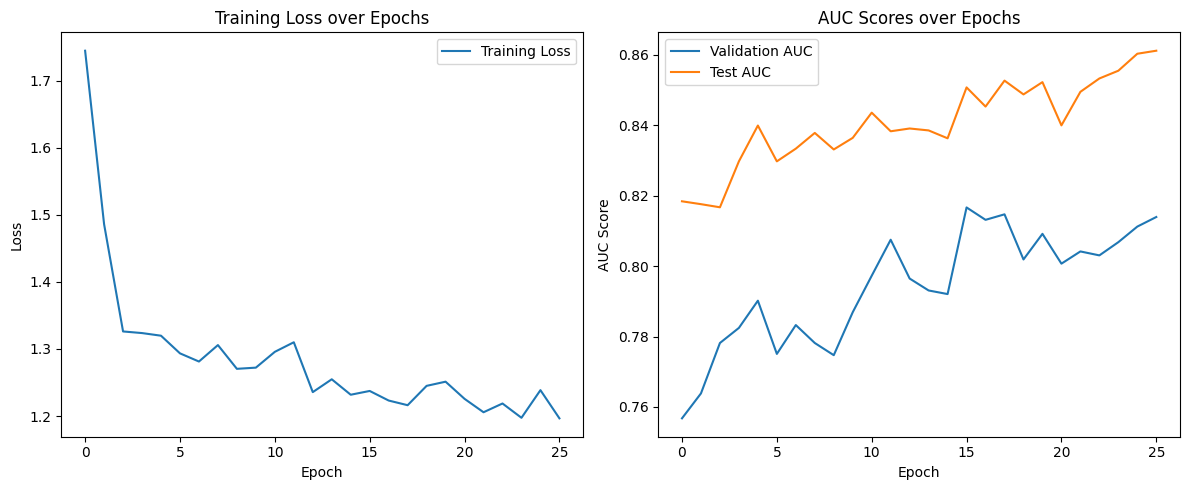

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# 1. Training Progress Plots
def plot_training_progress(train_losses, val_aucs, test_aucs):
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    
    # Plot AUC scores
    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='Validation AUC')
    plt.plot(test_aucs, label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.title('AUC Scores over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# 3. Save metrics to file
def save_metrics(train_losses, val_aucs, test_aucs):
    metrics_dict = {
        'train_loss': train_losses,
        'val_auc': val_aucs,
        'test_auc': test_aucs
    }
    np.save('training_metrics.npy', metrics_dict)

# Call the visualization functions
plot_training_progress(train_losses, val_aucs, test_aucs)
save_metrics(train_losses, val_aucs, test_aucs)

In [ ]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Read mappings from CSV
df = pd.read_csv('finalized_data.csv')

# Create gene and disease mappings
gene_to_idx = dict(zip(df['geneNcbiID'].unique(), range(len(df['geneNcbiID'].unique()))))
idx_to_gene = {v: k for k, v in gene_to_idx.items()}
disease_to_idx = dict(zip(df['diseaseName'].unique(), range(len(df['diseaseName'].unique()))))
idx_to_disease = {v: k for k, v in disease_to_idx.items()}

@torch.no_grad()
def get_readable_predictions(model, data, device):
    model.eval()
    model = model.to(device)
    data = data.to(device)
    
    # Get predictions
    pred = model(data)
    pred = pred.sigmoid().cpu().numpy()
    
    # Get edge indices
    edge_index = data['gene', 'associates_with', 'disease'].edge_label_index.cpu().numpy()
    
    # Create DataFrame with predictions and names
    df_pred = pd.DataFrame({
        'gene_idx': edge_index[0],
        'disease_idx': edge_index[1],
        'gene_ncbi': [idx_to_gene[idx] for idx in edge_index[0]],
        'disease_name': [idx_to_disease[idx] for idx in edge_index[1]],
        'prediction_score': pred
    })
    
    return df_pred

# Load best model and get predictions
model.load_state_dict(torch.load('best_model.pt'))
predictions_df = get_readable_predictions(model, test_data, device)



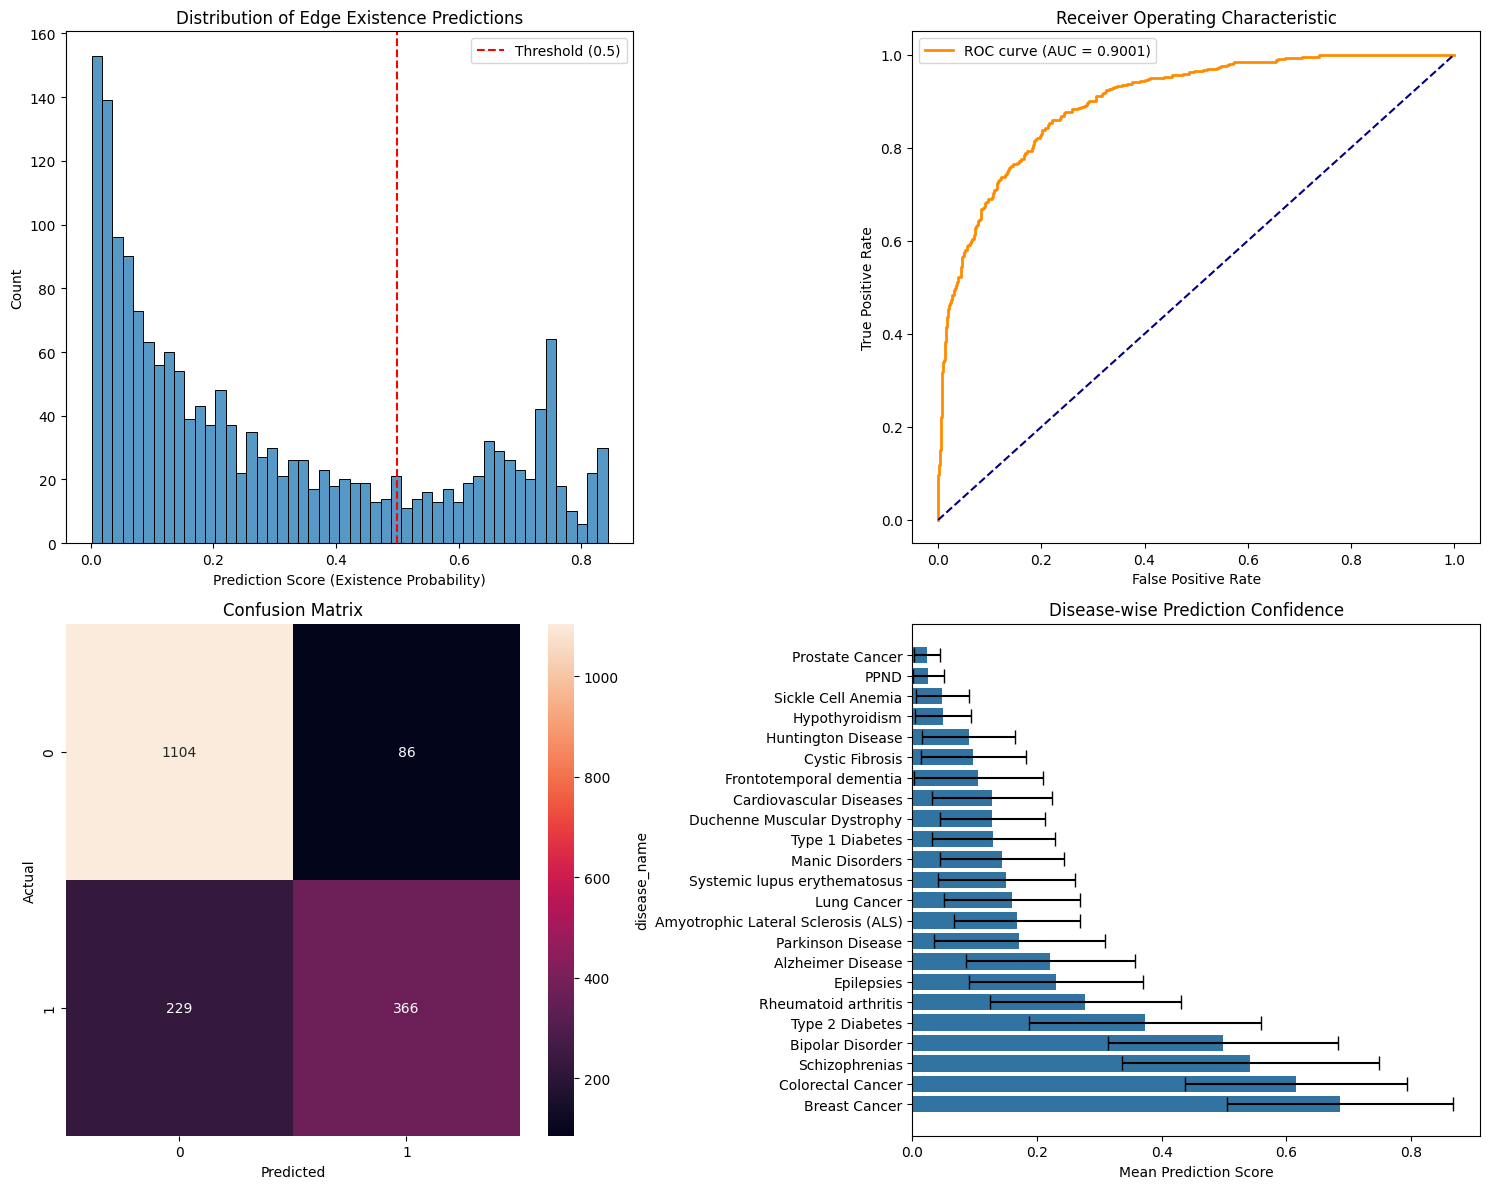


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88      1190
         1.0       0.81      0.62      0.70       595

    accuracy                           0.82      1785
   macro avg       0.82      0.77      0.79      1785
weighted avg       0.82      0.82      0.82      1785


Prediction Score Distribution:
Predictions >= 0.3: 689 (38.6%)
Predictions >= 0.5: 452 (25.3%)
Predictions >= 0.7: 223 (12.5%)
Predictions >= 0.9: 0 (0.0%)


In [53]:
def evaluate_link_prediction(predictions_df, test_data, threshold=0.5):
    """Evaluate binary link prediction performance"""
    from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
    
    # All edges in test set are positive examples (they exist)
    # Get true labels from test data
    y_true = test_data['gene', 'associates_with', 'disease'].edge_label.cpu().numpy()
    y_pred = (predictions_df['prediction_score'] >= threshold).astype(int)
    y_scores = predictions_df['prediction_score']
    
    # Create figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Prediction Score Distribution
    sns.histplot(data=predictions_df, x='prediction_score', bins=50, ax=ax1)
    ax1.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax1.set_title('Distribution of Edge Existence Predictions')
    ax1.set_xlabel('Prediction Score (Existence Probability)')
    ax1.legend()
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend()
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax3)
    ax3.set_title('Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    
    # 4. Disease-wise Performance (Fixed)
    disease_perf = predictions_df.groupby('disease_name')['prediction_score'].agg(['mean', 'std']).reset_index()
    disease_perf = disease_perf.sort_values('mean')
    
    # Create basic barplot
    sns.barplot(data=disease_perf, x='mean', y='disease_name', ax=ax4)
    
    # Add error bars manually
    ax4.errorbar(x=disease_perf['mean'], y=range(len(disease_perf)),
                xerr=disease_perf['std'], fmt='none', color='black', capsize=5)
    
    ax4.set_title('Disease-wise Prediction Confidence')
    ax4.set_xlabel('Mean Prediction Score')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Threshold analysis
    print("\nPrediction Score Distribution:")
    for t in [0.3, 0.5, 0.7, 0.9]:
        correct = (predictions_df['prediction_score'] >= t).sum()
        total = len(predictions_df)
        print(f"Predictions >= {t}: {correct} ({correct/total*100:.1f}%)")
    
    return y_true, y_pred, y_scores

# Run evaluation
y_true, y_pred, y_scores = evaluate_link_prediction(predictions_df,test_data)

In [54]:
import os
from datetime import datetime
def get_and_save_novel_predictions(model, data, device, batch_size=1024, output_file_prefix='novel_predictions'):
    model.eval()
    
    # Get ALL known edges from original data
    known_edges = set((int(i), int(j)) for i, j in data['gene', 'associates_with', 'disease'].edge_index.t().tolist())
    print(f"Known edges in original data: {len(known_edges)}")
    
    # Debug: Print some known edges
    print("Sample known edges:", list(known_edges)[:5])
    
    # Add timestamp to output file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"{output_file_prefix}_{timestamp}.csv"
    
    if not os.path.exists(output_file):
        pd.DataFrame(columns=['gene_idx', 'disease_idx', 'gene_ncbi', 'disease_name', 'prediction_score']).to_csv(output_file, index=False)
    
    try:
        # Generate novel pairs with explicit type conversion
        novel_pairs = []
        for g in range(data['gene'].num_nodes):
            for d in range(data['disease'].num_nodes):
                if (int(g), int(d)) not in known_edges:
                    novel_pairs.append([g, d])
        
        print(f"Novel pairs to evaluate: {len(novel_pairs)}")
        # Debug: Print some novel pairs
        print("Sample novel pairs:", novel_pairs[:5])
        
        # Process in batches
        for i in tqdm(range(0, len(novel_pairs), batch_size)):
            batch_pairs = novel_pairs[i:i+batch_size]
            edge_label_index = torch.tensor(batch_pairs, dtype=torch.long).t().to(device)
            
            batch_data = data.clone()
            batch_data['gene', 'associates_with', 'disease'].edge_label_index = edge_label_index
            batch_data = batch_data.to(device)
            
            with torch.no_grad():
                batch_pred = model(batch_data)
                pred_probs = batch_pred.sigmoid().cpu().numpy()
            
            batch_results = []
            for j, (pair, prob) in enumerate(zip(batch_pairs, pred_probs)):
                if prob >= 0.5:
                    batch_results.append({
                        'gene_idx': int(pair[0]),
                        'disease_idx': int(pair[1]),
                        'gene_ncbi': idx_to_gene[pair[0]],
                        'disease_name': idx_to_disease[pair[1]],
                        'prediction_score': float(prob)
                    })
            
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                batch_df.to_csv(output_file, mode='a', header=False, index=False)
    
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise
    
    # Verify results with explicit type conversion
    if os.path.exists(output_file):
        final_df = pd.read_csv(output_file)
        edge_pairs = set((int(row.gene_idx), int(row.disease_idx)) for _, row in final_df.iterrows())
        
        # Debug: Print some predicted edges
        print("Sample predicted edges:", list(edge_pairs)[:5])
        
        overlap = edge_pairs.intersection(known_edges)
        if overlap:
            print(f"Warning: Found {len(overlap)} predictions that were in training data!")
            print("Sample overlapping edges:", list(overlap)[:5])
        
        return final_df.nlargest(10, 'prediction_score')
    return None

# Execute with original data instead of test_data
print("Starting prediction generation...")
top_predictions = get_and_save_novel_predictions(model, data, device)
print("\nTop 10 Novel Predictions (score >= 0.5):")
print(top_predictions[['gene_ncbi', 'disease_name', 'prediction_score']])

Starting prediction generation...
Known edges in original data: 5524
Sample known edges: [(1664, 14), (1839, 15), (1443, 15), (1823, 7), (2260, 8)]
Novel pairs to evaluate: 77460
Sample novel pairs: [[0, 1], [0, 5], [0, 6], [0, 7], [0, 8]]


100%|██████████| 76/76 [00:00<00:00, 102.74it/s]


Sample predicted edges: [(1610, 7), (1797, 13), (2140, 7), (1744, 7), (2709, 15)]

Top 10 Novel Predictions (score >= 0.5):
      gene_ncbi   disease_name  prediction_score
1781       3481  Breast Cancer          0.809307
0          3630  Breast Cancer          0.806168
1165       4914  Breast Cancer          0.804016
168         627  Breast Cancer          0.803695
2033        836  Breast Cancer          0.801917
1379       7018  Breast Cancer          0.801333
200        2904  Breast Cancer          0.799978
964        4915  Breast Cancer          0.799090
112        5468  Breast Cancer          0.799002
550        5649  Breast Cancer          0.798446
